# Goal
* solve GW by FW
$$
\min_{\Gamma \in \Pi} -||2X \Gamma Y^T||_F^2 - <L,G> + c_0
$$

Algorithm
$$
L = 2  (\mu_y^T 1_y) m_x m_y^T - 4 m_x \mu_y Y^T Y - 4 X^TX \mu_x m_y
\\
\nabla_{\Gamma_t} f(\Gamma_t) = -8X^TX\Gamma_t Y^TY - L
\\
S_t = \text{argmin}_{S \in \Pi} <\Gamma_t,\nabla_\Gamma f(\Gamma)>
\\
\eta_t = \frac{-8 \text{tr}[(S_t - \Gamma_t )X^TX\Gamma_t Y^TY] - \text{tr}[L^T(S_t - \Gamma_t)]}{8 \text{tr}[S_t - \Gamma_t]X^TX(S_t - \Gamma_t)Y^TY}
\\
\Gamma_{t+1} = (1 - \eta_t)\Gamma_t + \eta_t S_t
$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [72]:
# random n points in 2D

n_sub = 300
n_mult = 3
n = nx = ny = n_sub * n_mult
np.random.seed(0)
X = np.random.rand(2, nx)
X[1, :] = np.concatenate(
    [np.arange(n // n_mult), np.arange(n // n_mult)[::-1], 2 * np.arange(n // n_mult)]
)
X[0, :] = np.arange(nx)
noise_eps = 10
# add noise
noise = noise_eps * (np.random.rand(2, ny) - 0.5)
Y = X + noise

In [73]:
nx = ny = n
mx = (np.linalg.norm(X, axis=0) ** 2).reshape(-1, 1)
my = (np.linalg.norm(Y, axis=0) ** 2).reshape(-1, 1)
vec_1x = np.ones_like(mx)
vec_1y = np.ones_like(my)

L = (nx + ny) * mx @ my.T - 4 * mx @ vec_1y.T @ Y.T @ Y - 4 * X.T @ X @ vec_1x @ my.T

In [74]:
import numpy as np
import ot
from collections import defaultdict


def objective(X, Y, Gamma, L):
    # Compute 2 * X * Gamma * Y^T
    Z = 2 * X @ Gamma @ Y.T
    frob_sq = np.sum(Z**2)  # ||·||_F^2
    inner_product = np.sum(L * Gamma)  # <L, Gamma>
    return -frob_sq - inner_product


def frank_wolfe_emd(X, Y, Gamma0, L, num_iters=100):
    dx, nx = X.shape
    dy, ny = Y.shape
    assert nx == ny

    # Initial coupling: uniform transport plan
    Gamma_t_plus_1 = Gamma0

    XtX = X.T @ X
    YtY = Y.T @ Y

    a = np.ones(nx)  # uniform source distribution
    b = np.ones(ny)  # uniform target distribution

    # log
    log = defaultdict(list)
    log["objective"].append(objective(X, Y, Gamma0, L))
    log["Gamma"].append(Gamma0)
    for t in range(num_iters):
        print("iter", t)
        # Gradient
        Gamma_t = Gamma_t_plus_1
        grad = -8 * XtX @ Gamma_t @ YtY - L

        # Linear oracle: solve transport problem using EMD
        C = grad  # cost matrix = gradient
        S = ot.emd(a, b, C)  # optimal coupling (transport plan)

        # Line search
        diff = S - Gamma_t
        numerator = -8 * np.trace(diff.T @ XtX @ Gamma_t @ YtY) - np.trace(L.T @ diff)
        denominator = 8 * np.trace(diff.T @ XtX @ diff @ YtY)
        eta = np.clip(numerator / denominator, 0, 1) if denominator > 1e-12 else 0

        # print('eta', eta)
        # print('Gamma_t', Gamma_t)
        # print('S', S)

        # Update
        Gamma_t_plus_1 = eta * Gamma_t + (1 - eta) * S
        # print('Gamma_t+1:', Gamma_t_plus_1)
        # print('Gamma_t - Gamma_t+1:', Gamma_t_plus_1 - Gamma_t)
        # print('||Gamma_t - Gamma_t+1||_F:', np.linalg.norm(Gamma_t_plus_1 - Gamma_t))
        # print('objective:', objective(X, Y, Gamma_t_plus_1, L))

        # Update Gamma_t
        log["objective"].append(objective(X, Y, Gamma_t_plus_1, L))
        log["Gamma"].append(Gamma_t_plus_1)
        log["eta"].append(0)
        log["Gamma_t"].append(Gamma_t_plus_1)
        log["S"].append(Gamma_t_plus_1)
        log["diff"].append(np.zeros_like(Gamma_t_plus_1))
        log["numerator"].append(0)
        log["denominator"].append(0)
        log["Gamma_t_plus_1"].append(Gamma_t_plus_1)

    return Gamma_t_plus_1, log

In [75]:
G0 = np.ones((nx, ny)) / nx
objective(X, Y, G0, L)

1.50882862036295e+17

In [76]:
G_fw, log_fw = frank_wolfe_emd(X, Y, G0, L, num_iters=10)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


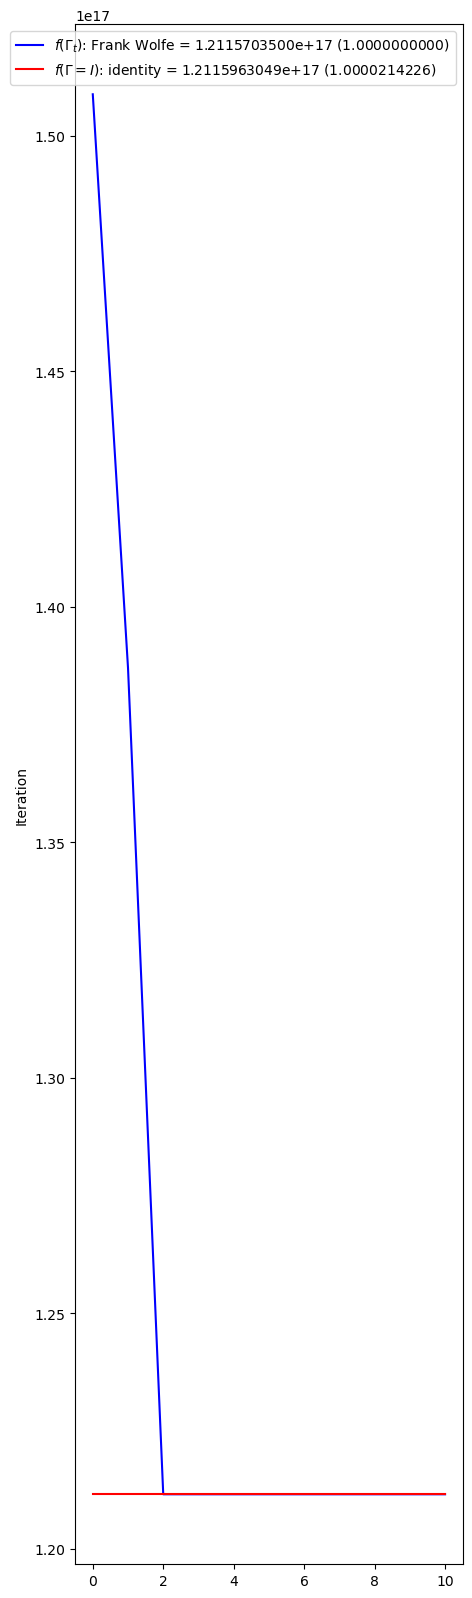

In [77]:
G_gt = np.eye(n)
f_I = objective(X, Y, G_gt, L)

G_gt = np.eye(n)
f_I = objective(X, Y, G_gt, L)
gw_fw = min(log_fw["objective"])

minimum = min(gw_fw, f_I)
f_I_relative = f_I / minimum
gw_fw_relative = gw_fw / minimum

plt.figure(figsize=(5, 20))
plt.plot(
    log_fw["objective"],
    label=r"$f(\Gamma_t)$: Frank Wolfe = "
    + "{:1.10e} ({:1.10f})".format(gw_fw, gw_fw_relative),
    color="blue",
)
plt.ylabel("Objective function")
plt.ylabel("Iteration")
plt.plot(
    f_I * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = I)$: identity = "
    + "{:1.10e} ({:1.10f})".format(f_I, f_I_relative),
    color="red",
)
plt.legend()

Text(0.5, 1.0, 'Transport plan $\\Gamma_{fw}$')

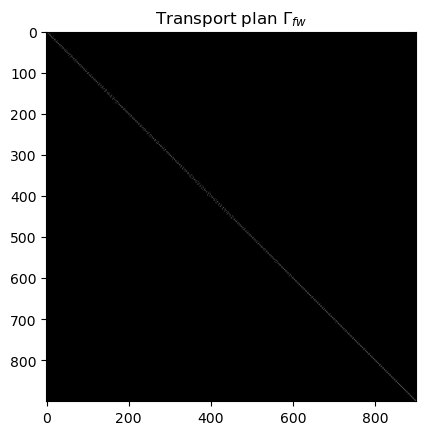

In [78]:
plt.imshow(G_fw, cmap="gray")
plt.title("Transport plan $\Gamma_{fw}$")

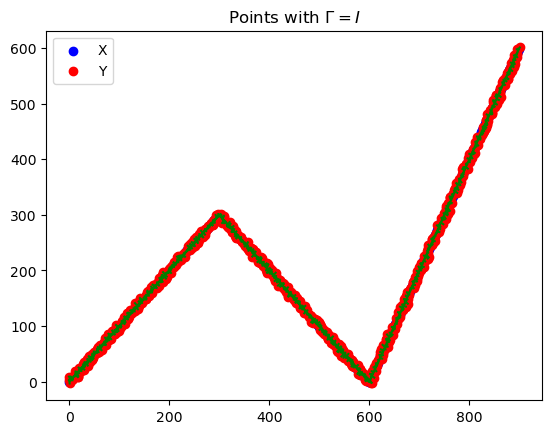

In [79]:
# plot X and Y on scatter, with lines connecting according to G
plt.figure()
plt.scatter(X[0], X[1], label="X", color="blue")
plt.scatter(Y[0], Y[1], label="Y", color="red")
for i in range(nx):
    for j in range(ny):
        if G_gt[i, j] > 0:
            plt.plot(
                [X[0, i], Y[0, j]], [X[1, i], Y[1, j]], color="green", alpha=G_gt[i, j]
            )
plt.legend()
plt.title("Points with $\Gamma = I$")
plt.show()

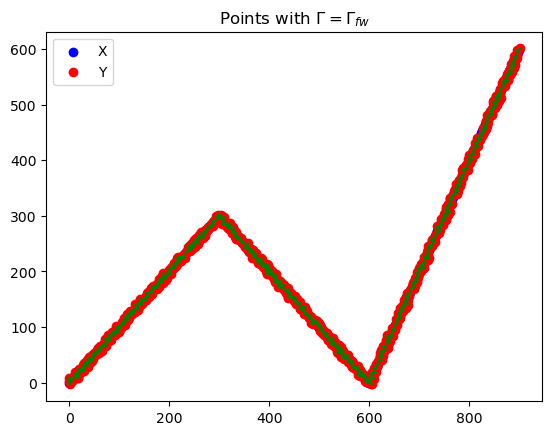

In [80]:
# plot X and Y on scatter, with lines connecting according to G
plt.figure()
plt.scatter(X[0], X[1], label="X", color="blue")
plt.scatter(Y[0], Y[1], label="Y", color="red")
for i in range(nx):
    for j in range(ny):
        if G_fw[i, j] > 0:
            plt.plot(
                [X[0, i], Y[0, j]], [X[1, i], Y[1, j]], color="green", alpha=G_fw[i, j]
            )
plt.legend()
plt.title("Points with $\Gamma = \Gamma_{fw}$")
plt.show()

# compare to ot.gw

In [81]:
# distance matrix for point clouds X and Y
C1 = ot.dist(X.T, X.T)
C2 = ot.dist(Y.T, Y.T)

gw_pot, log_pot = ot.gromov_wasserstein2(C1, C2, symmetric=True, log=True, verbose=True)
T_pot = log_pot["T"] * n

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.340201e+10|0.000000e+00|0.000000e+00
    1|4.332178e+10|6.943441e-01|3.008022e+10
    2|5.146010e+06|8.417519e+03|4.331664e+10
    3|4.901804e+06|4.981961e-02|2.442060e+05
    4|4.901804e+06|0.000000e+00|0.000000e+00


In [82]:
# plt.imshow(T_pot, cmap='gray')

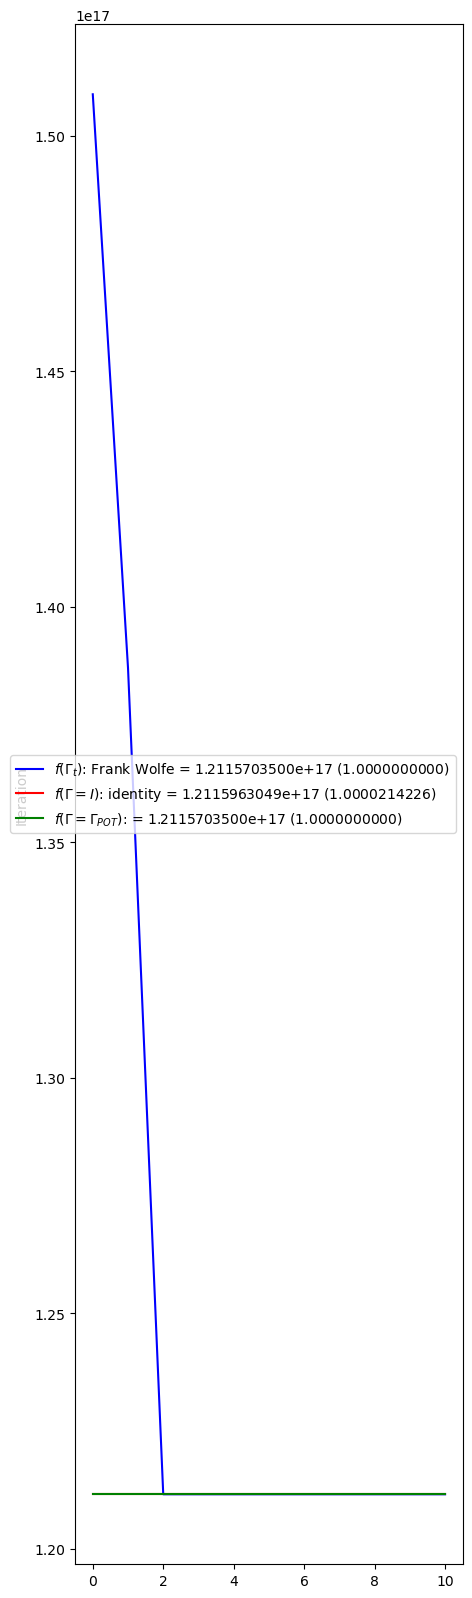

In [83]:
G_gt = np.eye(n)
f_I = objective(X, Y, G_gt, L)
gw_pot_objective = objective(X, Y, T_pot, L)
gw_fw = min(log_fw["objective"])

minimum = min(gw_fw, gw_pot_objective, f_I)
f_I_relative = f_I / minimum
gw_pot_objective_relative = gw_pot_objective / minimum
gw_fw_relative = gw_fw / minimum

plt.figure(figsize=(5, 20))
plt.plot(
    log_fw["objective"],
    label=r"$f(\Gamma_t)$: Frank Wolfe = "
    + "{:1.10e} ({:1.10f})".format(gw_fw, gw_fw_relative),
    color="blue",
)
plt.ylabel("Objective function")
plt.ylabel("Iteration")
plt.plot(
    f_I * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = I)$: identity = "
    + "{:1.10e} ({:1.10f})".format(f_I, f_I_relative),
    color="red",
)

plt.plot(
    gw_pot_objective * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = \Gamma_{POT})$: = "
    + "{:1.10e} ({:1.10f})".format(gw_pot_objective, gw_pot_objective_relative),
    color="green",
)

plt.legend()

# global gw

In [84]:
from cryo_challenge._map_to_map.gromov_wasserstein.ggw import gw_global

In [85]:
transport_plan_normalized, log_global = gw_global(
    X.T, Y.T, log=True, verbose=True, epsilon=1e-2, IterMax=100
)
T_global = transport_plan_normalized * n

do_optimize_with_sparse True
Iter |Bound gap
----------------------
0
    0|2.538773e+17
Zn [9.70664641e+08 4.48377740e+08 4.48616018e+08 2.14863353e+08]
betan 2.2504486956138253e+17
1
    1|6.232616e+16
Zn [4.84429023e+08 4.26808931e+08 4.48616018e+08 7.97305820e+07]
betan 1.568704528772624e+16
2
    2|3.974978e+16
Zn [8.30258665e+08 1.96584777e+08 1.96681074e+08 7.97305820e+07]
betan 5.20404617713795e+16
3
    3|9.574417e+15
Zn [5.17563873e+08 2.46417499e+08 1.96681074e+08 2.14863353e+08]
betan -2.372140927944163e+16
4
    4|8.974913e+15
Zn [8.19089441e+08 4.48377740e+08 4.26027399e+08 7.97305820e+07]
betan 1.3540546374288598e+17
5
    5|8.301982e+15
Zn [6.52011937e+08 4.48377740e+08 1.96681074e+08 2.14863353e+08]
betan 3.518227636816661e+16
6
    6|6.965133e+15
Zn [6.67922644e+08 1.96584777e+08 4.48616018e+08 2.14863353e+08]
betan 3.9879068289107e+16
7
    7|5.781695e+15
Zn [9.70664641e+08 4.48377740e+08 2.79517691e+08 1.95386104e+08]
betan 1.895957461363654e+17
8
    8|4.464909e+15

: 

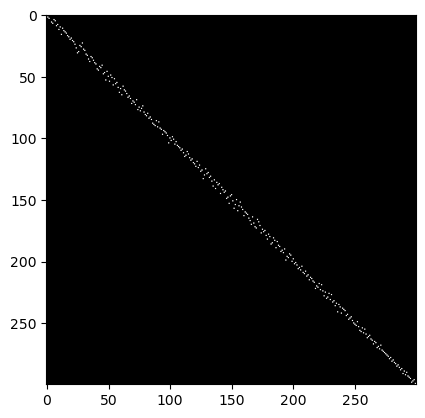

In [69]:
plt.imshow(transport_plan_normalized, cmap="gray")

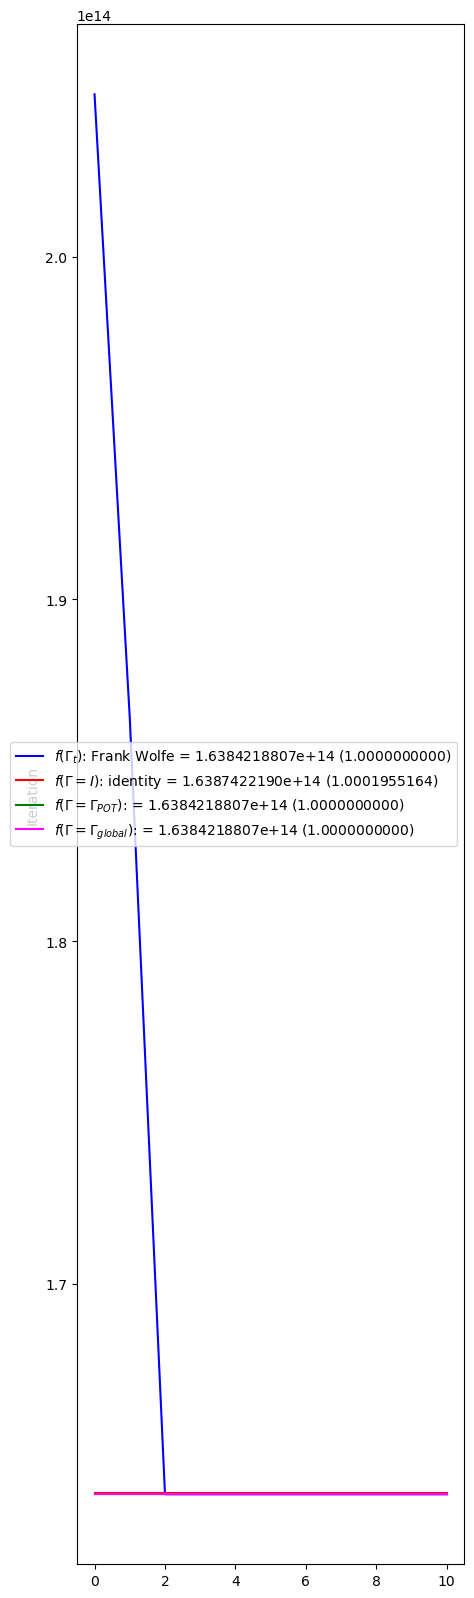

In [70]:
G_gt = np.eye(n)
f_I = objective(X, Y, G_gt, L)
gw_pot_objective = objective(X, Y, T_pot, L)
gw_fw = min(log_fw["objective"])
gw_global = objective(X, Y, T_global, L)

minimum = min(gw_fw, gw_pot_objective, gw_global, f_I)
f_I_relative = f_I / minimum
gw_pot_objective_relative = gw_pot_objective / minimum
gw_fw_relative = gw_fw / minimum
gw_global_relative = gw_global / minimum

plt.figure(figsize=(5, 20))
plt.plot(
    log_fw["objective"],
    label=r"$f(\Gamma_t)$: Frank Wolfe = "
    + "{:1.10e} ({:1.10f})".format(gw_fw, gw_fw_relative),
    color="blue",
)
plt.ylabel("Objective function")
plt.ylabel("Iteration")
plt.plot(
    f_I * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = I)$: identity = "
    + "{:1.10e} ({:1.10f})".format(f_I, f_I_relative),
    color="red",
)

plt.plot(
    gw_pot_objective * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = \Gamma_{POT})$: = "
    + "{:1.10e} ({:1.10f})".format(gw_pot_objective, gw_pot_objective_relative),
    color="green",
)

plt.plot(
    gw_global * np.ones_like(log_fw["objective"]),
    label=r"$f(\Gamma = \Gamma_{global})$: = "
    + "{:1.10e} ({:1.10f})".format(gw_global, gw_global_relative),
    color="magenta",
)


plt.legend()

In [71]:
np.isclose(gw_pot_objective_relative, 1, atol=1e-20)

True